In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def gen_1d_periodic_lattice(N, k):
    adj_list = {}
    for i in range(N):
        for j in range(k):
            if i not in adj_list:
                adj_list[i] = [(i+j+1)%N]
            else:
                adj_list[i].append((i+j+1)%N)
            adj_list[i].append((i-j-1)%N)

    return nx.Graph(adj_list)


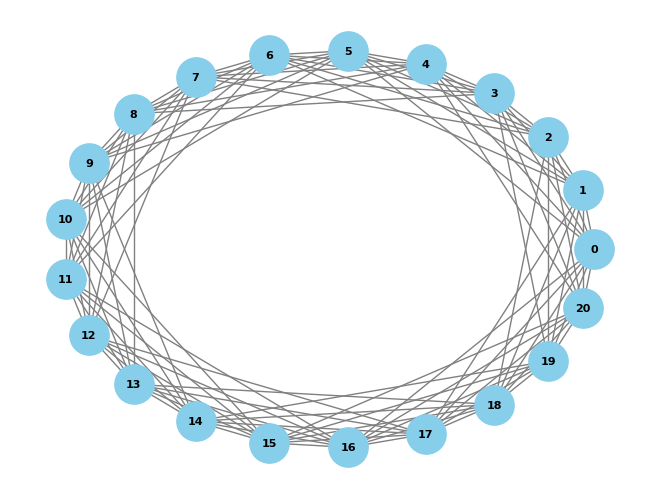

In [3]:
g = gen_1d_periodic_lattice(21, 5)
nx.draw(g, pos=nx.layout.circular_layout(g), with_labels=True, node_color='skyblue', node_size=800, font_size=8, font_color='black', font_weight='bold', edge_color='gray')

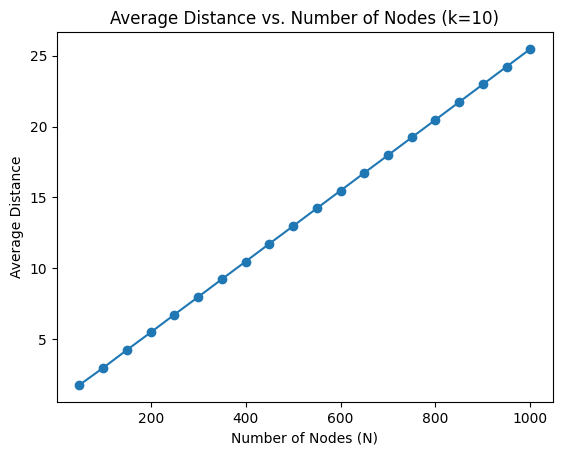

In [4]:
k = 10
N = range(50, 1001, 50)
d = []
for n in N:
    g = gen_1d_periodic_lattice(n, k)
    d.append(nx.average_shortest_path_length(g))

plt.plot(N, d, marker='o', linestyle='-')
plt.title(f'Average Distance vs. Number of Nodes (k={k})')
plt.xlabel('Number of Nodes (N)')
plt.ylabel('Average Distance')
plt.show()

What is the relation between the average distance and the number of nodes?

A linear relation can be drawn, approximately $f(N) = \frac{N}{40}$ for a constant $k = 10$.


Does it meet your expectations? Provide an interpretation of the plot.

Yes, it does. The observed linear relation aligns with the formula for the average distance $\langle d_{i,j} \rangle = \frac{n-1+2k}{4k}$. For $k=10$, this becomes:


$\langle d_{i,j} \rangle = \frac{n+19}{40}$

and as $n$ approaches infinity:

$\lim_{{n \to \infty}} \left( \frac{n+19}{40} \right) = \frac{n}{40}$

In [5]:
import random
random.seed(0)

def watts_strogatz(N, k, p):
    g = gen_1d_periodic_lattice(N, k)
    for i in range(N):
        for j in range(k):
            if random.random() < p:
                new_neighbor = random.choice(list(g.nodes - {i, (i + j + 1) % N, (i - j - 1) % N}))
                g.remove_edge(i, (i + j + 1) % N)
                g.add_edge(i, random.randint(0, new_neighbor))
    return g

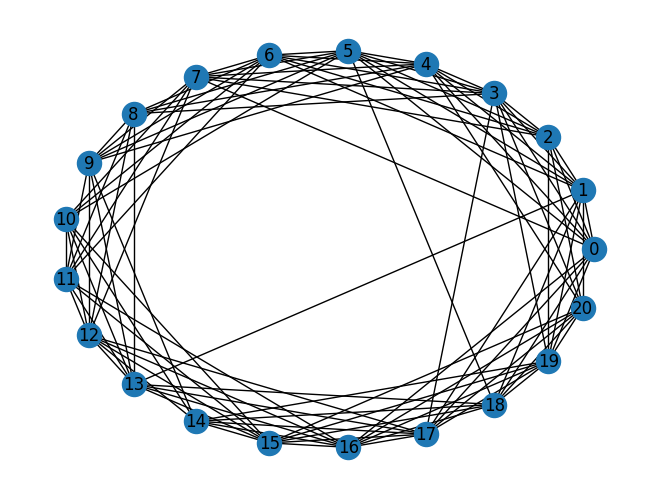

In [6]:
N = 21
k = 5
p = 0.1

g = watts_strogatz(N, k, p)
nx.draw(g, pos=nx.layout.circular_layout(g), with_labels=True)

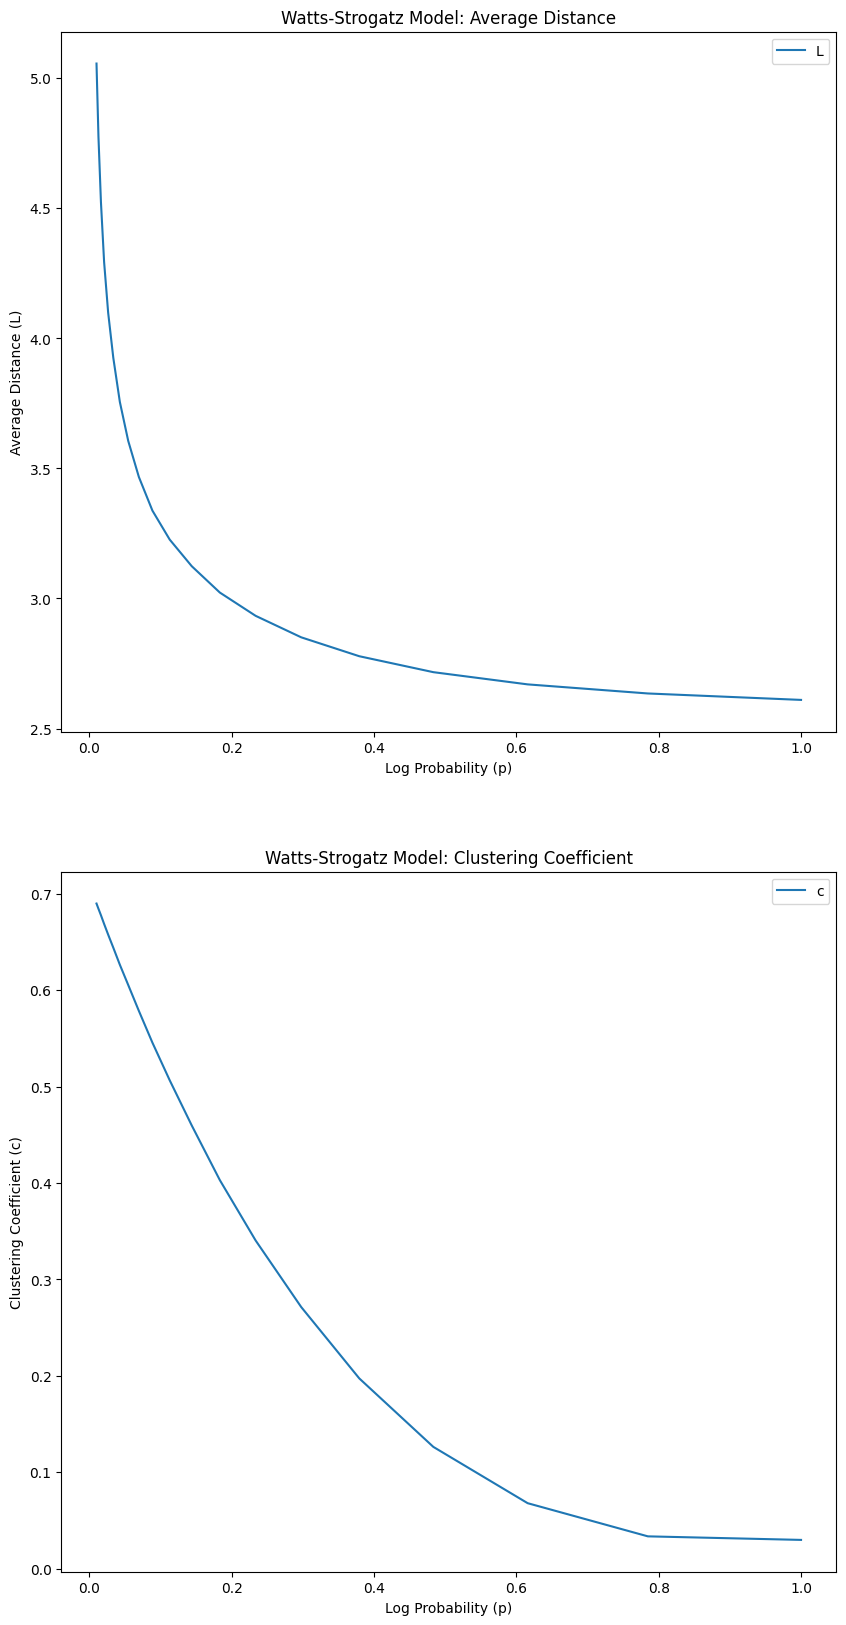

In [8]:
def compute_avg_L_and_c(N, k, num_samples=100):
    log_p = np.logspace(-2, 0, 20)
    avg_distances = []
    clustering_coefficients = []

    for p in log_p:
        avg_L_sum = 0
        avg_c_sum = 0

        for _ in range(num_samples):
            g = watts_strogatz(N, k, p)
            if not nx.is_connected(g):
                continue
            L = nx.average_shortest_path_length(g)
            c = nx.average_clustering(g)
            avg_L_sum += L
            avg_c_sum += c

        avg_distances.append(avg_L_sum / num_samples)
        clustering_coefficients.append(avg_c_sum / num_samples)

    return log_p, avg_distances, clustering_coefficients

N = 1000
k = 10
num_samples = 50

p_values, avg_distances, clustering_coefficients = compute_avg_L_and_c(N, k, num_samples)

plt.figure(figsize=(10, 20))

plt.subplot(2, 1, 1)
plt.xlabel('Log Probability (p)')
plt.ylabel('Average Distance (L)')
plt.title('Watts-Strogatz Model: Average Distance')
plt.plot(p_values, avg_distances, label='L')
plt.legend()

plt.subplot(2, 1, 2)
plt.xlabel('Log Probability (p)')
plt.ylabel('Clustering Coefficient (c)')
plt.title('Watts-Strogatz Model: Clustering Coefficient')
plt.plot(p_values, clustering_coefficients, label='c')
plt.legend()

plt.show()
